In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
import numpy as np

import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


from osse import *
from sloped_MITgcm import *
nancol = (0.65,0.65,0.65)

In [3]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

In [4]:
data_dir = f"../../MITgcm/experiments/rotated_BBTRE_canyon/input/"

In [5]:
ds = xr.open_dataset(data_dir+"geocoords_original.nc")
newds = xr.open_dataset(data_dir+"geocoords.nc")

In [6]:
min_elv = newds.attrs['min_elv']
Hz = newds.attrs['Hz']
dz0 = newds.attrs['dz0']

Hbot = newds['z'] - min_elv - (Hz - dz0)

Hremoved = newds['z_slope'] + min_elv
Hoffset = Hremoved + (Hz-dz0)

In [7]:
lon1 = -18.3; lon2 = lon1; lon3 = lon1; 
lat1 = -21.7; lat2 = lat1; lat3 = lat1;

In [8]:
x = newds['Xr'].values[:]
z = newds['Z'].values[:]

sec_j = newds['Yr'].size//2-4


# Moorings
geo = xr.open_dataset(data_dir+"geocoords.nc").drop(["X", "Y"])
moorings = {
    #"CTS17-P1": {'coords': (-14.58, -21.12)},
    "CTS17-P2": {'coords': (-14.59, -21.10)},
    "T05": {'coords': (-17.-48.5/60., -21.-36.9/60.)}
}

lons = [mooring['coords'][0] for mooring in moorings.values()]
lats = [mooring['coords'][1] for mooring in moorings.values()]
markers = ['v', 's']#['o', 'v', 's']
samples = sample_locations(geo, lons, lats)

In [9]:
import pandas as pd

###
T05 = pd.read_csv("../../data/Thurnherr2005.csv")

T05_dep = np.array([
    np.float(T05["Unnamed: 4"][1]),
    np.float(T05["Unnamed: 7"][1]),
    np.float(T05["Unnamed: 10"][1])
])

<ipython-input-9-76b62a835071>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(T05["Unnamed: 4"][1]),
<ipython-input-9-76b62a835071>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.float(T05["Unnamed: 7"][1]),
<ipython-input-9-76b62a835071>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To s

In [20]:
experiments = ["idealized-plane-1D", "idealized-plane", "idealized-canyon", "idealized-sill", "canyon-tracer"]
longnames = {
    'canyon-tracer': "BBTRE",
    'idealized-sill': "Canyon+Sill",
    'idealized-canyon': "Canyon",
    'idealized-plane': "Smooth3D",
    'idealized-plane-1D': "1D",
}
nexp = len(experiments)

data = {}
for exp in experiments:
    data[exp] = xr.open_dataset(f"../../data/BBTRE-physics/buoyancy_{exp}.nc")
    data[exp].attrs['H'] = data[exp]['Depth'].max(skipna=True).values

<ipython-input-21-4b2b9214c0d6>:25: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(lon, lat, "ro", marker=marker, markeredgecolor='k', markersize=9, label=label, linestyle='None')
<ipython-input-21-4b2b9214c0d6>:28: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s="Tracer Release", xy=(lon1+0.085, lat1-0.1), horizontalalignment="left", verticalalignment="center", fontsize=16, color="w")
<ipython-input-21-4b2b9214c0d6>:45: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.annotate(s=r"$\hat{x}$", xy=(Xa+0.48, Ya-0.12), fontsize=18)
<ipython-input-21-4b2b9214c0d6>:46: MatplotlibDeprecationWarning:

idealized-plane
idealized-canyon
idealized-sill


<ipython-input-21-4b2b9214c0d6>:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


canyon-tracer


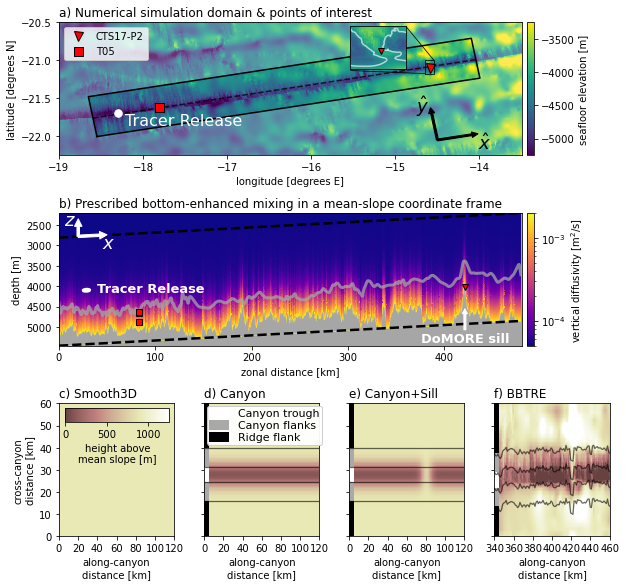

In [21]:
labels = ["c)", "d)", "e)", "f)"]

plt.rcParams['font.size'] = 10

scale_fig = 0.55
fig = plt.figure(figsize=(16*scale_fig,15*scale_fig))
gs = fig.add_gridspec(3, 4)

### XY
ax1 = fig.add_subplot(gs[0, :])

clims = [-5250, -3250]
q = ds['z'].plot.pcolormesh(x='lon', y='lat')
plt.fill_between([-25, -10], [-30, -30], [0, 0], facecolor="w", alpha=0.20)
q.set_rasterized(True)
q.set_clim(clims)
q.colorbar.remove()
q = (newds['z_actual']).plot(x='lon', y='lat')
q.set_clim(clims)
q.colorbar.remove()
plt.colorbar(q, pad=0.01, label=r"seafloor elevation [m]")
plt.plot([newds['lon'].isel(Xr=0, Yr=sec_j), newds['lon'].isel(Xr=-1, Yr=sec_j)], [newds['lat'].isel(Xr=0, Yr=sec_j), newds['lat'].isel(Xr=-1, Yr=sec_j)], "k--", alpha=0.75)

for lon, lat, marker, label in zip(samples['lon'], samples['lat'], markers, list(moorings.keys())):
    plt.plot(lon, lat, "ro", marker=marker, markeredgecolor='k', markersize=9, label=label, linestyle='None')
plt.legend()
plt.plot(lon1, lat1, "wo", markersize=7.5)
plt.annotate(s="Tracer Release", xy=(lon1+0.085, lat1-0.1), horizontalalignment="left", verticalalignment="center", fontsize=16, color="w")

plt.plot(
    [newds['lon'].isel(Xr=0, Yr=0), newds['lon'].isel(Xr=0, Yr=-1), newds['lon'].isel(Xr=-1, Yr=-1), newds['lon'].isel(Xr=-1, Yr=0), newds['lon'].isel(Xr=0, Yr=0)],
    [newds['lat'].isel(Xr=0, Yr=0), newds['lat'].isel(Xr=0, Yr=-1), newds['lat'].isel(Xr=-1, Yr=-1), newds['lat'].isel(Xr=-1, Yr=0), newds['lat'].isel(Xr=0, Yr=0)],
    "k-"
)

X0 = newds['lon'].isel(Xr=0, Yr=0);
Xx = newds['lon'].isel(Xr=-1, Yr=0);
Xy = newds['lon'].isel(Xr=0, Yr=-1);
Y0 = newds['lat'].isel(Xr=0, Yr=0);
Yx = newds['lat'].isel(Xr=-1, Yr=0);
Yy = newds['lat'].isel(Xr=0, Yr=-1)
Xa = -14.5; Ya = -22.05;
plt.arrow(Xa, Ya, (Xx-X0)*0.09, (Yx-Y0)*0.09, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
plt.arrow(Xa, Ya, (Xy-X0)*0.67, (Yy-Y0)*0.67, head_width = 0.075, head_length = 0.075, width=0.025, color="k")
plt.annotate(s=r"$\hat{x}$", xy=(Xa+0.48, Ya-0.12), fontsize=18)
plt.annotate(s=r"$\hat{y}$", xy=(Xa-0.25, Ya+0.365), fontsize=18)
plt.title("")
plt.xlabel("longitude [degrees E]")
plt.ylabel("latitude [degrees N]")
plt.xticks(np.arange(-19, -13, 1))
plt.yticks(np.arange(-22.5, -20, 0.5))

plt.ylim([-22.25, -20.5])
plt.xlim([-19, -13.5])

xsill = [-14.645, -14.545]
ysill = [-21.175, -20.995]

plt.plot(
    [xsill[0], xsill[0], xsill[1], xsill[1], xsill[0]],
    [ysill[0], ysill[1], ysill[1], ysill[0], ysill[0]],
    "k-", lw=0.75
)

plt.plot([-15.53, xsill[0]], [-21.135, ysill[0]], "k", lw=0.75)
plt.plot([-14.87, xsill[1]], [-20.559, ysill[1]], "k", lw=0.75)
plt.title("a) Numerical simulation domain & points of interest", loc='left')

axins = plt.axes([0, 0, 1, 1])
ip = InsetPosition(ax1, [0.63, 0.65, 0.12, 0.325]) #posx, posy, width, height
axins.set_axes_locator(ip)
q = ds['z'].plot.pcolormesh(ax=axins, x='lon', y='lat')
q.set_clim(clims)
q.colorbar.remove()
CS = ds['z'].plot.contour(ax=axins, x='lon', y='lat', colors='w', levels=[-4250, np.nan], linestyles="solid", alpha=0.65)
axins.set_xticks([])
axins.set_xticklabels([])
axins.set_xlabel("")
axins.set_yticks([])
axins.set_yticklabels([])
axins.set_ylabel("")
axins.set_title("")
for lon, lat, marker, label in zip(samples['lon'], samples['lat'], markers, list(moorings.keys())):
    axins.plot(lon, lat, "ro", marker=marker, markeredgecolor='k', markersize=6.5, label=label, linestyle='None')
axins.set_xlim(xsill)
axins.set_ylim(ysill)

### XZ
ax2 = fig.add_subplot(gs[1, :], facecolor=nancol)
q = plt.pcolor(x[np.newaxis,:]*1e-3, z[:,np.newaxis]+Hoffset.values,newds['K'][:,sec_j,:].values, norm=matplotlib.colors.LogNorm(vmin=5.e-5, vmax=2.e-3), cmap="plasma")
plt.xlabel('zonal distance [km]')
plt.ylabel('depth [m]')
plt.colorbar(q, pad=0.01, label=r"vertical diffusivity [m$^{2}$/s]")
plt.fill_between(x*1e-3, Hremoved - 10, Hbot[sec_j,:]+Hoffset, facecolor=nancol)
plt.fill_between(x*1e-3, Hremoved + (Hz-50.), np.zeros_like(x), facecolor=cm.plasma(0.))

plt.plot(x*1e-3, Hremoved, "k--", lw=2.5)
plt.plot(x*1e-3, Hremoved+(Hz-dz0), "k--", lw=2.5)
plt.plot(Hbot['Xr']*1e-3, (Hbot+Hoffset).isel(Yr=np.append(np.arange(-10,0), np.arange(0,10))).mean(dim='Yr'), color=nancol, lw=3.0, alpha=0.75)

plt.contour(x[np.newaxis,:]*1e-3 + 0.*z[:,np.newaxis], z[:,np.newaxis]+Hoffset.values, newds['BBTRE'].values[:,sec_j,:], levels=[0.37, np.nan], colors="w", linewidths=2.5)

plt.annotate(s="Tracer Release", xy=(40, -4150), color="w", fontsize=13, weight="bold")
plt.annotate(
    s="DoMORE sill", xytext=(421.25, -5275), xy=(421.25, -4550), color="w", fontsize=13, weight="bold",
    va="center", ha="center",
    arrowprops=dict(headlength=5, width=2, headwidth=5, color='w')
)

CTS17dep = newds["z_actual"].isel(Yr=sec_j, Xr=samples["i"][0]).values
plt.plot(newds["Xr"][samples["i"][0]]*1e-3, CTS17dep, "r", marker=markers[0], markeredgecolor='k', markersize=5.5)
for i in range(0,3):
    plt.plot(newds["Xr"][samples["i"][1]]*1e-3, -T05_dep[i], "r", marker=markers[1], markeredgecolor='k', markersize=5.5)

plt.yticks(np.arange(-5000, -2000, 500), np.arange(5000, 2000, -500))

plt.xlim([0, 600.*newds['Xr'].size*1e-3])
plt.ylim([Hremoved.min(), (Hremoved + (Hz-dz0)).max()])

θ = 0.0012618506382207175
X0 = 20e3; Z0 = -2780;
Mag = 30e3;
arrowprops = dict(headlength=7.5, width=2.5, headwidth=7.5, color='w')
X1 = X0 + Mag*np.cos(θ); Z1 = Z0 + Mag*np.sin(θ)
plt.annotate("", (X1*1e-3, Z1), (X0*1e-3, Z0), arrowprops=arrowprops, xycoords="data")
scale = 1/70.
X2 = X0 - Mag*np.sin(θ)*scale; Z2 = Z0 + Mag*np.cos(θ)*scale
plt.annotate("", (X2*1e-3, Z2), (X0*1e-3, Z0), arrowprops=arrowprops, xycoords="data")
plt.annotate(s=r"$z$", xy=(X0*1e-3-15, Z0+285), fontsize=18, color="w")
plt.annotate(s=r"$x$", xy=(X0*1e-3+25, Z0-300), fontsize=18, color="w")
plt.title("b) Prescribed bottom-enhanced mixing in a mean-slope coordinate frame", loc='left')

##
topo_cmap = cmap = truncate_colormap(cm.get_cmap('pink'),0.1,1.)

for i, (k,v) in enumerate(data.items(), start=-1):
    if i<0: continue
    print(k, end="\n")
    ax = fig.add_subplot(gs[2, i])
    extra = 0.

    if i==0: extra=800;
    if i==3: extra=-300;
    PC = (-v['Depth']+v.attrs['H']+extra+100).plot(ax=ax, cmap=topo_cmap)
    PC.colorbar.remove()
    PC.set_clim([0, 1250])
    if i>=1:
        x0 = 0.
        if i==nexp-2: x0 = 340e3;
        y0 = v['YC_thalweg'].sel(XC=x0, method='nearest')
        ax.plot([x0, x0], [y0-dx*6, y0+dx*6], "w", lw=10., solid_capstyle='butt', label='Canyon trough')# gold
        ax.plot([x0, x0], [y0-dx*6, y0-dx*20], "darkgrey", lw=10., solid_capstyle='butt', label='Canyon flanks')# b
        ax.plot([x0, x0], [y0+dx*6, y0+dx*20], "darkgrey", lw=10., solid_capstyle='butt') # C3
        ax.plot([x0, x0], [0.e3, y0-dx*20], "k", lw=10., solid_capstyle='butt', label='Ridge flank')
        ax.plot([x0, x0], [y0+dx*20, 60e3], "k", lw=10., solid_capstyle='butt')

        (v['YC_thalweg']-dx*6).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=0.6, lw=1.25)
        (v['YC_thalweg']+dx*6).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=0.6, lw=1.25)

        (v['YC_thalweg']-dx*20).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=0.6, lw=1.25)
        (v['YC_thalweg']+dx*20).coarsen(XC=2).mean().plot(ax=ax, color='k', alpha=0.6, lw=1.25)

        if i==1:
            ax.legend(fontsize=11, handlelength=1.85, labelspacing=0.185, framealpha=0.95, borderpad=0.2, borderaxespad=0.25)

    ax.set_xlim([0, 120e3])
    yticks = np.arange(0,70,10)
    ax.set_yticks(yticks*1e3)
    ax.set_yticklabels(yticks.astype('int64'))
        
    if i==nexp-2:
        add_to_xticks = 340e3
    else:
        add_to_xticks = 0.;
    ax.set_xlim([add_to_xticks, add_to_xticks+120e3])
    xticks = np.arange(0,140,20)+(add_to_xticks*1e-3)
    ax.set_xticks(xticks*1e3)
    ax.set_xticklabels(xticks.astype('int64'))
    if i==0:
        ax.set_ylabel("cross-canyon\ndistance [km]")
    else:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    ax.set_xlabel("along-canyon\ndistance [km]")
    ax.set_title(f"{labels[i]} {longnames[k]}", loc="left", fontsize=12)
    
    if i==0:
        #axcb = plt.axes([0, 0, 1, 1])
        #ipcb = InsetPosition(ax, [0., 0, 0.2, 0.8]) #posx, posy, width, height
        #axcb.set_axes_locator(ipcb)
        axcb = inset_axes(ax,
                    width="90%",  # width = 50% of parent_bbox width
                    height="10%",  # height : 5%
                    loc='upper right')
        fig.colorbar(PC, cax=axcb, orientation='horizontal', label='height above\nmean slope [m]')

plt.tight_layout()
plt.savefig(f"../../figures/BBTRE/domain_configuration.png", dpi=200., bbox_inches='tight')